# Задание 3. Утечка данных через модель

Цель: Понять риски, связанные с утечкой данных.

Задание:

﻿ ﻿1.﻿ Возьмите обученную модель отсюда, натренированную на конфиденциальных данных (id).

﻿ ﻿2.﻿ ﻿Выполните membership inference attack, чтобы определить, является ли конкретный пример частью тренировочного набора.



Во время второго этапа, разрешено использовать методы predict и predict_proba исходной модели. Любые другие методы исходной модели использовать запрещено!



In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

## Оригинальная модель

In [13]:
df = pd.read_csv("/content/breast-cancer.csv")

l = LabelEncoder()
df['diagnosis'] = l.fit_transform(df.diagnosis)

x = df.drop('diagnosis', axis=1)
y = df['diagnosis']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(xtrain, ytrain)

RandomForestClassifier(random_state=42)

In [15]:
y_pred = model.predict(xtest)
print("model name is", model)
print("accuracy is", round(accuracy_score(y_pred, ytest), 2) * 100, '%')
print("precision is", round(precision_score(y_pred, ytest), 2) * 100, '%')
print("recall is", round(recall_score(y_pred, ytest), 2) * 100, '%')
print("f1 is", round(f1_score(y_pred, ytest), 2) * 100, '%')

model name is RandomForestClassifier(random_state=42)
accuracy is 96.0 %
precision is 93.0 %
recall is 98.0 %
f1 is 95.0 %


## Атака

Ограничение в задаче ("разрешено использовать только predict и predict_proba") значит, что нельзя использовать методы вроде .score(), .feature_importances_ или внутренние параметры модели для извлечения дополнительных данных.

Membership Inference Attack основана на том, что модели могут переобучаться на тренировочных данных, выдавая для них более уверенные предсказания (predict_proba) по сравнению с данными, на которых модель не обучалась.

Для этой задачи мы обучаем вторичную (атакующую) модель, которая классифицирует, является ли пример частью обучающего набора или нет. Для атакующей модели мы будем использовать:

* Максимальная вероятность (confidence)
* Энтропия предсказаний - измеряет степень неопределенности в распределении вероятностей. Если модель уверена в своем предсказании то энтропия будет низкой.
* Метки: 1 для примеров из тренировочного набора, 0 для тестовых данных.

In [16]:
# Собираем предсказания и вероятности
train_probs = model.predict_proba(xtrain)
train_preds = model.predict(xtrain)
train_labels = np.ones(len(xtrain))  # Метка 1 для тренировочных данных

test_probs = model.predict_proba(xtest)
test_preds = model.predict(xtest)
test_labels = np.zeros(len(xtest))  # Метка 0 для тестовых данных

In [17]:
# Вычисление признаков для атакующей модели
def compute_features(probs):
    confidence = np.max(probs, axis=1)  # # Максимальная вероятность (уверенность)
    entropy = -np.sum(probs * np.log(probs + 1e-10), axis=1)  # Энтропия
    return np.vstack((confidence, entropy)).T

In [18]:
# Подготовка датасета для атакующей модели
train_features = compute_features(train_probs)
test_features = compute_features(test_probs)

attack_features = np.vstack((train_features, test_features))
attack_labels = np.hstack((train_labels, test_labels))

X_train_attack, X_test_attack, y_train_attack, y_test_attack = train_test_split(
    attack_features, attack_labels, test_size=0.3, random_state=42
)

In [19]:
# Датафрейм для визуализации
attack_df = pd.DataFrame(attack_features, columns=['Confidence', 'Entropy'])
attack_df['Target'] = attack_labels
print("Attack dataset preview:")
print(attack_df.head())

# Подсчет количества классов 0 и 1
class_counts = attack_df['Target'].value_counts()

print("Class counts: ", class_counts)

Attack dataset preview:
   Confidence       Entropy  Target
0        0.86  4.049635e-01     1.0
1        1.00 -1.000000e-10     1.0
2        1.00 -1.000000e-10     1.0
3        0.96  1.679441e-01     1.0
4        0.99  5.600153e-02     1.0
Class counts:  Target
1.0    455
0.0    114
Name: count, dtype: int64


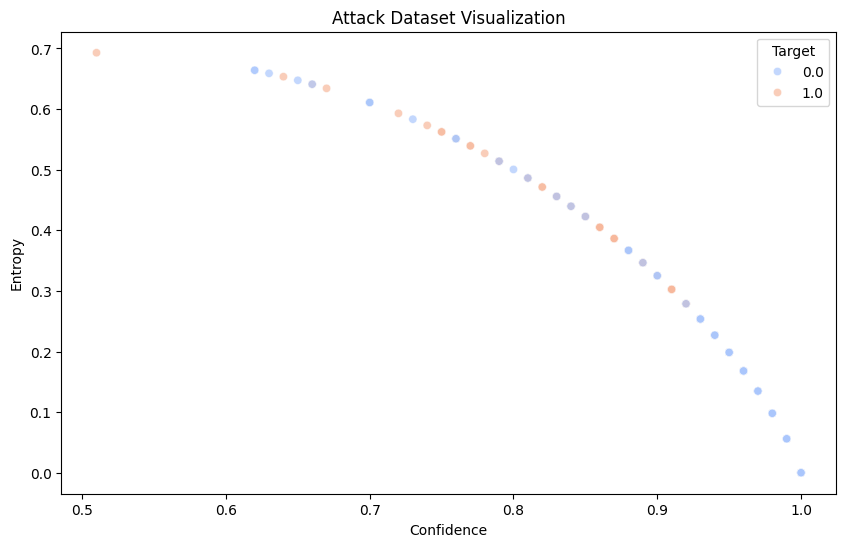

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(data=attack_df, x='Confidence', y='Entropy', hue='Target', palette='coolwarm', alpha=0.7)
plt.title('Attack Dataset Visualization')
plt.xlabel('Confidence')
plt.ylabel('Entropy')
plt.legend(title='Target')
plt.show()

In [21]:
from sklearn.ensemble import GradientBoostingClassifier

attack_model = GradientBoostingClassifier(
    n_estimators=30,       # Количество деревьев в бустинге
    learning_rate=0.1,      # Скорость обучения
    max_depth=3,            # Максимальная глубина деревьев
    min_samples_split=2,     # Минимальное количество образцов для разделения узла
    min_samples_leaf=1,     # Минимальное количество образцов в листовом узле
    random_state=42         # Для воспроизводимости
)
attack_model.fit(X_train_attack, y_train_attack)

GradientBoostingClassifier(n_estimators=30, random_state=42)

In [22]:
y_pred_attack = attack_model.predict(X_test_attack)
print("model name is Attack model", attack_model)
print("accuracy is", round(accuracy_score(y_test_attack, y_pred_attack), 2) * 100, '%')
print("precision is", round(precision_score(y_test_attack, y_pred_attack), 2) * 100, '%')
print("recall is", round(recall_score(y_test_attack, y_pred_attack), 2) * 100, '%')
print("f1 is", round(f1_score(y_test_attack, y_pred_attack), 2) * 100, '%')

model name is Attack model GradientBoostingClassifier(n_estimators=30, random_state=42)
accuracy is 79.0 %
precision is 80.0 %
recall is 99.0 %
f1 is 88.0 %


Метрики находятся на хорошем уровне, f1 в 88% указывает, что, балансируя точность и полноту, мы можем получить уверенный доступ к конфиденциальной информации. Атака успешна